In [4]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

%matplotlib inline

### <p style="text-align: center; color: green;">Motion Compensation Block Based</p>  

#### (A) Au TP1, vous avez réalisé de l’estimation de mouvement de type forward  par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par  blocs entre F1 et F2.

3 procédés nécessaires :  
    - vecteurs de mouvement  
    - l'image I1  
    - différence entre I2 et notre prédiction de I2  

In [19]:
OPTI_SLICING = 8
SEARCH_DIST_PIXEL = 4

BLOCK_LEN = 12
SEARCH_DIST_BLOCK = 12

LOOP_IMAGES = 1

In [20]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def estimate(deltaIntensity, dist):
    return 2 * deltaIntensity + dist / SEARCH_DIST_PIXEL

class Image:

    def __init__(self, pathImg):
        self.img = cv2.imread(pathImg)
        self.grayImage = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.height, self.width = self.grayImage.shape[:2]

    # (A) Pixel-wise
    def differencePixelWise(self, other):
        vectors = np.full((self.height, self.width, 2), np.inf)
        # Get the indexes of the pixels to loop through
        y_idx = np.arange(0, self.height, OPTI_SLICING)
        x_idx = np.arange(0, self.width, OPTI_SLICING)

        # Get the indexes of the search area
        y2_idx, x2_idx = np.indices((2 * SEARCH_DIST_PIXEL + 1, 2 * SEARCH_DIST_PIXEL + 1))
        y2_idx -= SEARCH_DIST_PIXEL
        x2_idx -= SEARCH_DIST_PIXEL
        
        for i in range(len(y_idx)):
            for j in range(len(x_idx)):
                y2_idx_tmp = y2_idx + y_idx[i]
                x2_idx_tmp = x2_idx + x_idx[j]
                # Make sure the indexes are in the image
                y2_idx_tmp = np.clip(y2_idx_tmp, 0, self.height-1)
                x2_idx_tmp = np.clip(x2_idx_tmp, 0, self.width-1)
                # Get the intensity of the pixel and the intensity of the pixel in the search area
                intensity1 = self.grayImage[y_idx[i], x_idx[j]]
                intensity2 = other.grayImage[y2_idx_tmp, x2_idx_tmp]
                deltaIntensity = np.abs(intensity2 - intensity1)
                dist = distance(x_idx[j], y_idx[i], x2_idx_tmp, y2_idx_tmp)
                estimation = estimate(deltaIntensity, dist)
                # Get the indexes of the minimum value inside estimation
                idx = np.unravel_index(np.argmin(estimation, axis=None), estimation.shape)
                vectors[y_idx[i], x_idx[j], 0] = (x2_idx_tmp[idx] - x_idx[j]) * 2
                vectors[y_idx[i], x_idx[j], 1] = (y2_idx_tmp[idx] - y_idx[i]) * 2
        return vectors


    # (B) Block-wise
    def differenceBlockWise(self, other):
        vectors = np.zeros((self.height, self.width, 2))
        # Loop through all blocks
        for y in range(BLOCK_LEN//2, self.height, BLOCK_LEN):
            for x in range(BLOCK_LEN//2, self.width, BLOCK_LEN):
                # Get the block
                block = self.grayImage[y-BLOCK_LEN//2:y+BLOCK_LEN//2, x-BLOCK_LEN//2:x+BLOCK_LEN//2]
                # Make sure the block is the right size
                if block.shape != (BLOCK_LEN, BLOCK_LEN):
                    block = cv2.resize(block, (BLOCK_LEN, BLOCK_LEN))
                # Get the search area
                yMoves = np.arange(max(y-SEARCH_DIST_BLOCK, 0), min(y+SEARCH_DIST_BLOCK, self.height))
                xMoves = np.arange(max(x-SEARCH_DIST_BLOCK, 0), min(x+SEARCH_DIST_BLOCK, self.width))

                # Get the differences
                diff = np.zeros((len(yMoves), len(xMoves)))
                for i in range(len(yMoves)):
                    for j in range(len(xMoves)):
                        # Get the block in the search area
                        block2 = other.grayImage[max(yMoves[i]-BLOCK_LEN//2, 0):min(yMoves[i]+BLOCK_LEN//2, self.height), max(xMoves[j]-BLOCK_LEN//2, 0):min(xMoves[j]+BLOCK_LEN//2, self.width)]
                        # Make sure the blocks are the same size for border issues
                        if block2.shape != block.shape:
                            block2 = cv2.resize(block2, (BLOCK_LEN, BLOCK_LEN))
                        
                        # Get the difference using the estimation function
                        diff[i, j] = np.sum(2 * np.abs(block2 - block) + distance(x, y, xMoves[j], yMoves[i]))

                # Get the index of the minimum difference
                idx = np.unravel_index(np.argmin(diff, axis=None), diff.shape)
                # Get the vector
                vectors[y, x, 0] = (xMoves[idx[1]] - x)
                vectors[y, x, 1] = (yMoves[idx[0]] - y)
        return vectors

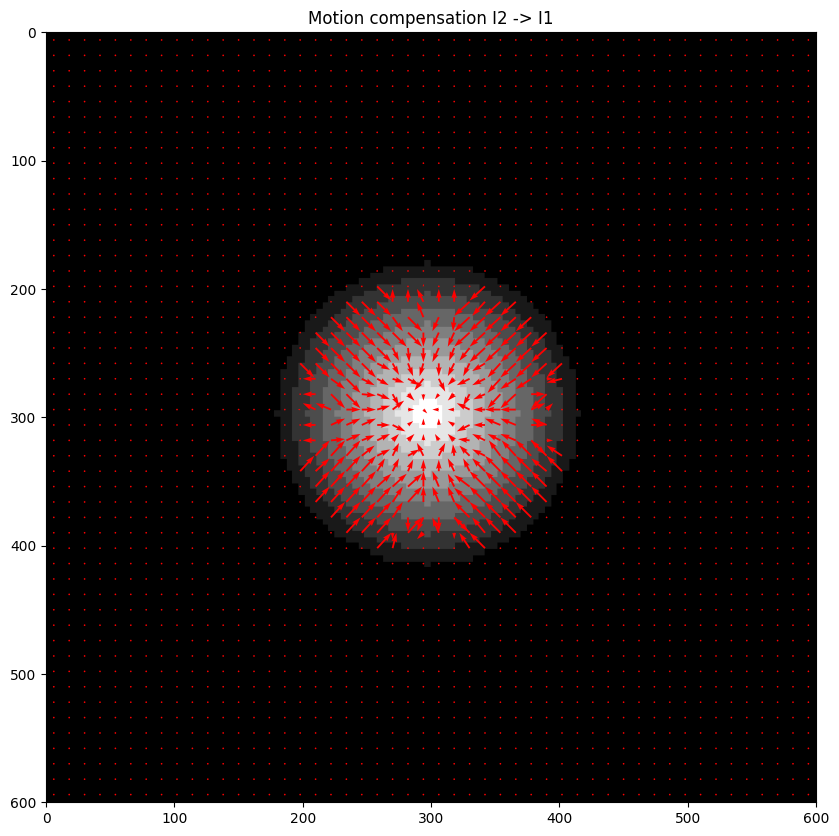

In [21]:
# create a new figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Charger les deux images
img1 = Image('1.png')
img2 = Image('2.png')

ax.clear()
ax.imshow(cv2.cvtColor(img2.img, cv2.COLOR_BGR2RGB))

# Calcul des vecteurs de mouvement
vectors = img2.differenceBlockWise(img1)

# draw the vectors using quiver
ax.quiver(np.arange(BLOCK_LEN // 2, img1.width, BLOCK_LEN), np.arange(BLOCK_LEN // 2, img1.height, BLOCK_LEN),
            vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 0], vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 1],
            angles='xy', scale_units='xy', scale=1, color='r')

# set the x and y limits of the plot
ax.set_xlim([0, img1.width])
ax.set_ylim([0, img1.height])
ax.set_title('Motion compensation I2 -> I1')

# Reverse the image
ax.invert_yaxis()

# show the plot
plt.show()